# Scanning URLs from Images
> A Streamlit app powered by AWS Rekognition.

- toc: true 
- badges: true
- comments: true
- categories: [streamlit, python, aws]
- image: images/text_detections.jpeg

# Scanning QR codes for humans: URLs

The idea for this popped up when talking to my mom about how QR codes work.
The simple usecase for QR codes is the same as a URL: get the user to a certain website.

So why can't we just scan a real URL with our cameras...?
(*spoiler:* many modern android and ios devices can, but that's a short end to the story)

I'm all for QR codes being used for more things, but URLs aren't going away any time soon for a few reasons:
- Not everybody knows how to make a QR code (*hint*: write click on a page in Chrome or use the [python-qrcode](https://github.com/lincolnloop/python-qrcode) library)
- URLs often contain the company name so people can remember them (qr codes can contain logos in some cases)
- URLs are a single line (most of the time) rather than taking up a whole square of printing / advertising space

I also wanted to give a live [Streamlit](https://docs.streamlit.io/) app a shot after using it for some AI demos with students.
So was born the [Streamlit URL Scanner](https://share.streamlit.io/gerardrbentley/streamlit-url-scanner/main/streamlit_app/streamlit_app.py)!

In this notebook I'll breakdown the basic mechanisms behind the app, see the full source code [on github](https://github.com/gerardrbentley/streamlit-url-scanner/blob/main/streamlit_app/streamlit_app.py)

## Python Dependencies

There are 3 goals for this app:
- Allow user to upload images containing URLs to the web app
- Run high-accuracy Optical Character Recognition (OCR) on the uploaded image
- Provide any URLs from the extracted text to the user for easy clicking

I went with the libraries that I thought would give the fastest and most successful development experience.

### Python Web App

- `streamlit`: Python rapid development web app framework 
    - Provides a file upload component out of the box with `st.file_uploader`
    - Simple Cloud deployment with secure secrets for OCR component

Contenders
- `fastapi`: Providing a route to OCR component as a service 
    - Asynchronous by default is nice for handling distributed transactions to OCR task
- `django`: Overbaked for usecase
    - This is a proof of concept tool, not a full-stack user-oriented website
- `flask` / `bottle`: 
    - Have ways of being asynchronous, but synchronous by default

All of these other options would require a frontend app or integrating some JS library or other `index.html` + JS + CSS combination

### OCR

- AWS Rekognition: Trained for text detection on real world images
    - Limited to 100 words detected
    - Accessed with the `boto3` library

Contenders
- AWS Textract: More tuned for documents than real world
- Tesseract: Still a good OCR, but also focused on documents
    - Can be self-hosted, not paid per transaction


### URL Extraction

- `urlextract`: I didn't want to write a regex for URLs when there's a small library without [any known issues](https://snyk.io/advisor/python/urlextract)


### Glue Code

- `PIL` / Pillow: Python Imaging Library for handling user uploaded images and resizing if needed
- `pydantic`: Typed Settings management with loading from CLI, Environment, Secrets

In [4]:
import io
import json

import boto3
import streamlit as st
from PIL import Image, ImageDraw, ImageOps
from pydantic import BaseSettings
from urlextract import URLExtract

## OCR + Extractor Setup

Pydantic's `BaseSettings` Class allows us to read in settings for connecting to AWS account.
This can be used with Docker secrets, but this app is deployed to Streamlit cloud.

`boto3` lets us establish a client to the Rekognition service.

URL Extract requires some initialization to recognize all domain names. 

In [6]:
class Settings(BaseSettings):
    """Handles fetching configuration from environment variables and secrets.
    Type-hinting for config as a bonus"""

    aws_access_key_id: str
    aws_secret_access_key: str
    aws_region: str

settings = Settings()

rekog_client = boto3.client(
    "rekognition",
    region_name=settings.aws_region,
    aws_access_key_id=settings.aws_access_key_id,
    aws_secret_access_key=settings.aws_secret_access_key,
)

extractor = URLExtract()

2022-01-27 18:44:24.510 INFO    filelock: Lock 139763555315184 acquired on /home/gar/miniconda3/lib/python3.8/site-packages/urlextract/data/tlds-alpha-by-domain.txt.lock
2022-01-27 18:44:24.555 INFO    filelock: Lock 139763555315184 released on /home/gar/miniconda3/lib/python3.8/site-packages/urlextract/data/tlds-alpha-by-domain.txt.lock


## Detecting Text in an Image

AWS Rekognition can receive either a path to an S3 object or raw image bytes.
For this app I went with passing just the image bytes, so a helper function to compress larger images was needed.
We'll ignore the streamlit specific alert message that this is happening for this demo.
(The S3 version isn't much more complicated, and is beneficial for more general OCR apps)

Another small helper for passing the correct parameters to boto3 will wrap up this section.

`Pillow` will do our image handling in the app, so we'll use it for showing a demo detection in the following code cells 

In [8]:
def compress_pil_image(image: Image, limit=(5 * (2 ** 20))) -> bytes:
    """Takes a Pillow image and returns byte values of the image saved as png.
    Reduces dimensions of image if it is larger than provided limit.

    Args:
        image (Image): Image to get the bytes for
        limit (int, optional): Maximum number of bytes. Defaults to 5mb (5 * (2 ** 20)).

    Returns:
        bytes: image saved as PNG bytes object
    """
    image_bytes = io.BytesIO()
    image.save(image_bytes, "PNG")
    output = image_bytes.getvalue()

    limit_to_bytes_ratio = limit / len(output)

    if limit_to_bytes_ratio >= 1.0:
        return output
    else:
        # st.warning(f"Resizing by ratio: {limit_to_bytes_ratio}")
        width, height = image.size
        new_width = int(width * limit_to_bytes_ratio)
        new_height = int(height * limit_to_bytes_ratio)
        new_image = image.resize((new_width, new_height), Image.ANTIALIAS)
        return compress_pil_image(new_image, limit)


def rekog_detect_by_bytes(image_bytes: bytes) -> dict:
    """Takes an array of bytes representing jpg / png image.
    Tries to return response from AWS Rekognition detect_text API on the image bytes
    See docs for more: https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/rekognition.html#Rekognition.Client.detect_text  # noqa: E501

    Args:
        image_bytes (bytes): Image to run detection on (less than 5 mb)

    Returns:
        dict: List of text detections, geometry of the detections, and metadata
    """
    response = rekog_client.detect_text(Image={"Bytes": image_bytes})
    return response

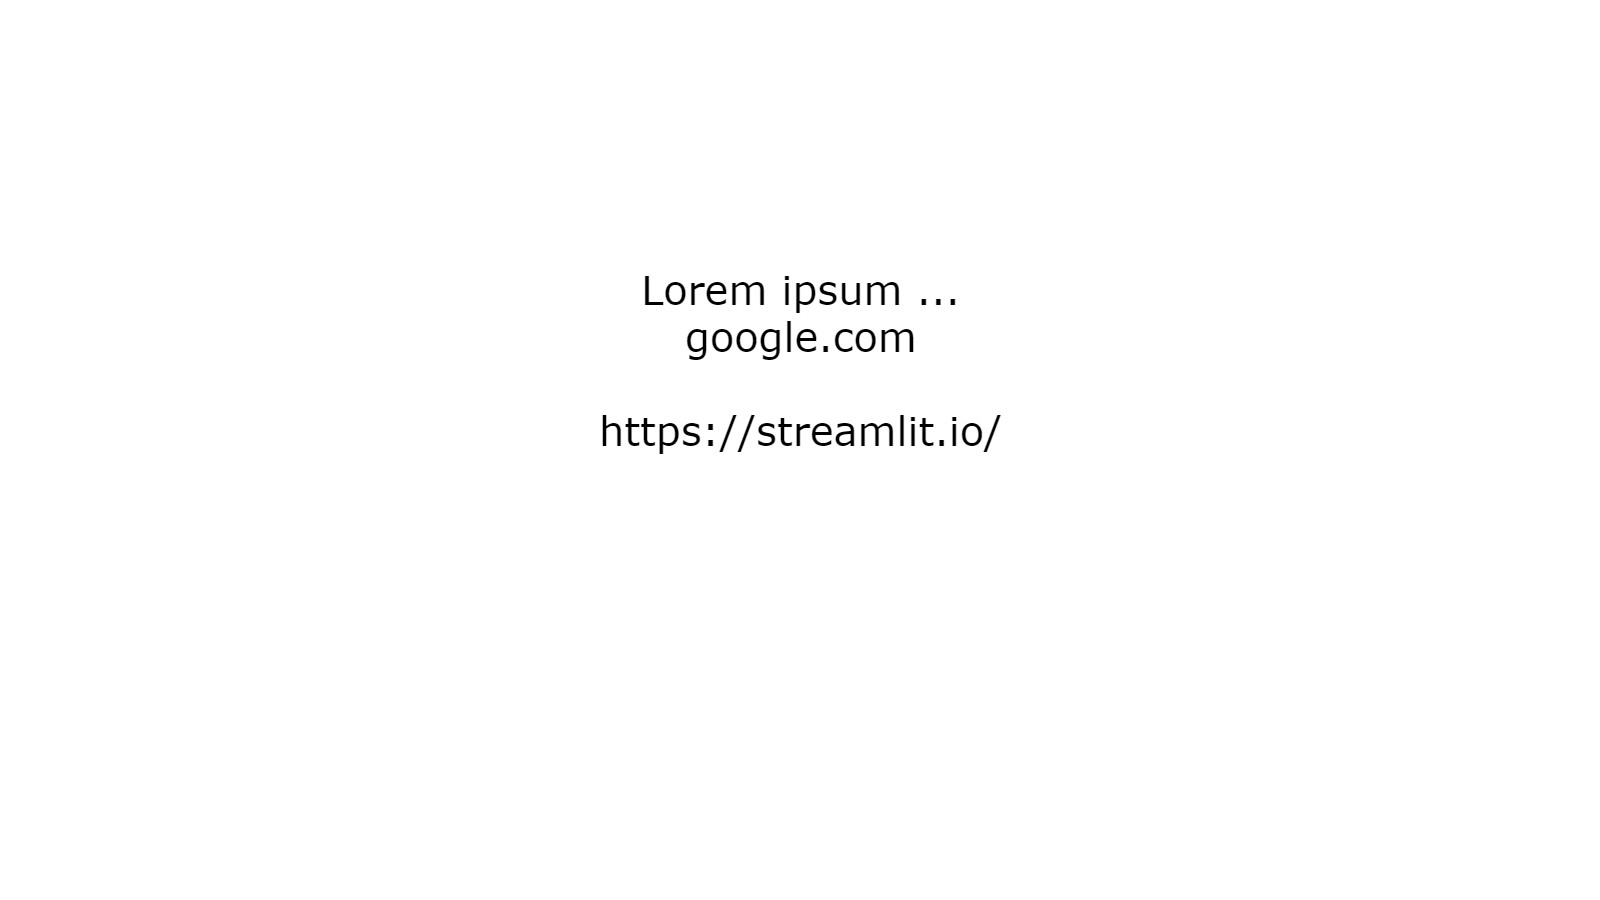

In [9]:
demo_image = Image.open('test_images/sample_urls.jpg')
demo_image

In [10]:
image_bytes = compress_pil_image(demo_image)
rekognotion_response = rekog_detect_by_bytes(image_bytes)
rekognotion_response

{'TextDetections': [{'DetectedText': 'Lorem ipsum...',
   'Type': 'LINE',
   'Id': 0,
   'Confidence': 83.6632080078125,
   'Geometry': {'BoundingBox': {'Width': 0.198333278298378,
     'Height': 0.05164804682135582,
     'Left': 0.4017779529094696,
     'Top': 0.3004961609840393},
    'Polygon': [{'X': 0.4021288752555847, 'Y': 0.3004961609840393},
     {'X': 0.6001112461090088, 'Y': 0.3018783628940582},
     {'X': 0.5997602939605713, 'Y': 0.3521442115306854},
     {'X': 0.4017779529094696, 'Y': 0.3507620096206665}]}},
  {'DetectedText': 'google.com',
   'Type': 'LINE',
   'Id': 1,
   'Confidence': 99.61248779296875,
   'Geometry': {'BoundingBox': {'Width': 0.142822265625,
     'Height': 0.0458984375,
     'Left': 0.428466796875,
     'Top': 0.3544921875},
    'Polygon': [{'X': 0.428466796875, 'Y': 0.3544921875},
     {'X': 0.5712890625, 'Y': 0.3544921875},
     {'X': 0.5712890625, 'Y': 0.400390625},
     {'X': 0.428466796875, 'Y': 0.400390625}]}},
  {'DetectedText': 'https://streamlit

## Extracting URLs from Text

If you're not familiar with APIs or bounding boxes the above output might be a bit of a mess.
That's alright, we're here to work through it.

Rekognition's text detection returns a List of "Text Detection" records.
Each of these "Text Detections" has a few features, but the most important to our purpose is "Detected Text."

If we're really just interested in the text, we can use a list comprehension to get the detections and pass them to the URL extractor

In [12]:
detected_text = [detection['DetectedText'] for detection in rekognotion_response['TextDetections'] if detection["Type"] == "LINE"]
extracted_urls = extractor.find_urls(" ".join(detected_text))
extracted_urls

['google.com', 'https://streamlit.io/']

## Streamlit aspect

Streamlit provides the frontend components for uploading and viewing images and links.
(And giving a semblance of user experience)

It's hard to demo these aspects in a notebook, but here are the streamlit snippets and use cases in the app.

```py
# Header and Description 
st.title("URL Scan :computer:")
st.header(
    "Never type a URL from real life again! "
    "Take a picture with a URL in it and we'll scan any links so you can click them!"
)
st.subheader("(Or upload an image you already have on your device)")

# Retrieve image from camera or upload
camera_bytes = st.camera_input("Take a picture")
uploaded_bytes = st.file_uploader(
    "Upload an image",
    type=["png", "jpg", "jpeg"],
)

# Context manager to give better loading experience
with st.spinner("Loading Image Bytes"):
    # Compress pil image
    pass

# Provide visual alerts to the user
st.success(
    f"Found {len(extracted_urls)} URLs!"
)

# Allow downloading the detected text / urls
st.download_button(
    label="Download extracted url list",
    data='\n'.join(extracted_urls),
    file_name="extracted_urls.txt",
    mime="text",
)

# Display the raw and detected images
st.image(
    demo_image,
    use_column_width=True,
)
```

## Testing and deployment

Docker is used to help smooth environments between windows / linux / mac.
Docker-compose is used to open up to future extensions with other backend apps.

Linting, Static Checking, and Testing are handled locally before deployment.

E2E testing consists of Selenium visual baseline testing against locally deployed app in docker-compose

Deployment would be straightforward with docker-compose, but Streamlit cloud provides plenty of resources for this use case.
Not having to write a CI/CD pipeline is fine by me.

Downsides are the need to deploy secrets manually to streamlit and it requires setting up a seperate app deployment if a staging / UAT environment is desired.

## BONUS: Painting detections

The url extraction code used above isn't the same process as used in the app.
I think the bounding box aspect of text detection is engaging for users to understand the OCR component, so I include a copy of their image with the bounding boxes painted on.

We get all of the location data in the "Text Detections" from Rekognition, but we have to do a bit of conversion from their format to draw them with Pillow's ImageDraw.
In this case we're converting from a format that provides the Width, Height, Left-side X coordinate, and Top-side Y coordinate in percentage of the image size.

Our goal is to use some arithmetic to get the (X,Y) coordinates of the top-left corner of our bounding box and the bottom-right corner in pixels.
(If you haven't worked with bounding boxes, there's even more possible formats...)

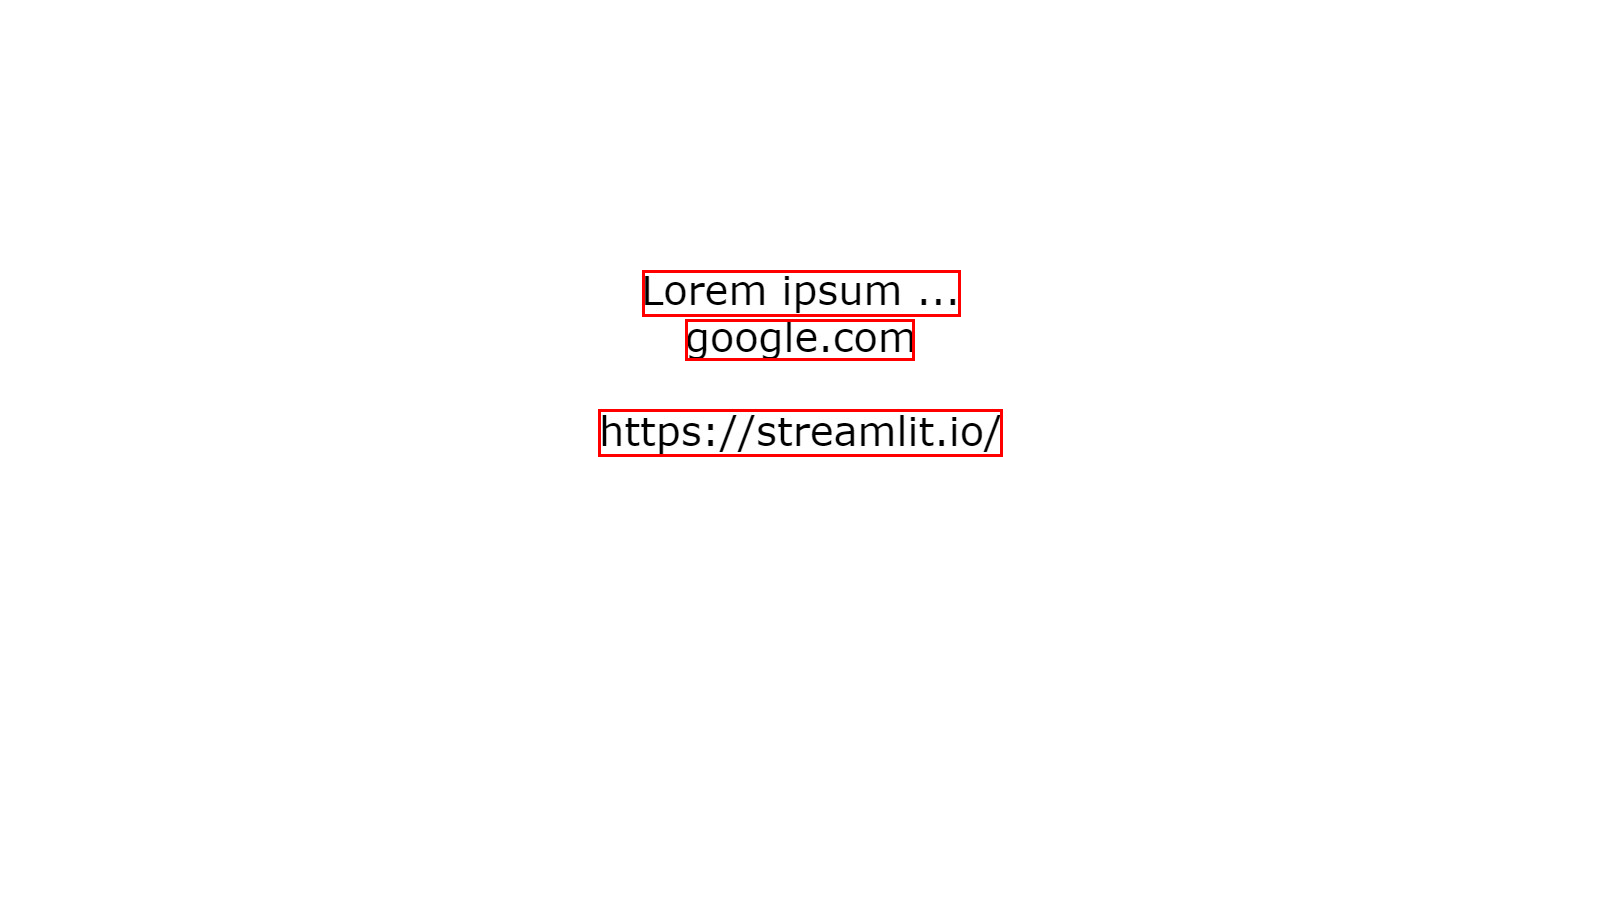

In [13]:
image_w, image_h = demo_image.size
painted_image = demo_image.copy()
canvas = ImageDraw.Draw(painted_image)
for detection in rekognotion_response["TextDetections"]:
    if detection["Type"] == "LINE":
        text = detection["DetectedText"]
        aws_bbox = detection["Geometry"]["BoundingBox"]
        top_left_x = aws_bbox["Left"] * image_w
        top_left_y = aws_bbox["Top"] * image_h
        box_width = aws_bbox["Width"] * image_w
        box_height = aws_bbox["Height"] * image_h
        bot_right_x = top_left_x + box_width
        bot_right_y = top_left_y + box_height
        canvas.rectangle(
            (top_left_x, top_left_y, bot_right_x, bot_right_y),
            outline="Red",
            width=3,
        )
painted_image